In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval

In [36]:
FOLDER_PATH = 'data/'
DATA_COLUMNS = ['wiki_movie_id', 'freebase_movie_id', 'movie_name',
       'movie_box_office_revenue', 'movie_runtime', 'languages', 'countries',
       'genres', 'imdb_id', 'cast', 'rating', 'votes', 'budget', 'plot',
       'characters_names', 'main_character', 'release_year']
df = pd.read_csv(FOLDER_PATH + 'movie_processed.csv', names=DATA_COLUMNS, header=0, index_col=0)

In [37]:
df.head()

,wiki_movie_id,freebase_movie_id,movie_name,movie_box_office_revenue,movie_runtime,languages,countries,genres,imdb_id,cast,rating,votes,budget,plot,characters_names,main_character,release_year
0,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,['English'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...",228333.0,"['Natasha Henstridge', 'Ice Cube', 'Jason Stat...",4.9,55370.0,28000000.0,"Set in the second half of the 22nd century, th...","['Akooshay', 'Lieutenant Melanie Ballard', 'De...",Lieutenant Melanie Ballard,2001.0
1,9363483,/m/0285_cd,White Of The Eye,NaN,110.0,['English'],['United Kingdom'],"['Thriller', 'Erotic thriller', 'Psychological...",NaN,NaN,NaN,NaN,NaN,A series of murders of rich young women throug...,[],NaN,1987.0
2,261236,/m/01mrr1,A Woman in Flames,NaN,106.0,['German'],['Germany'],['Drama'],83949.0,"['Gudrun Landgrebe', 'Mathieu Carrière', 'Hann...",6.0,591.0,NaN,"Eva, an upper class housewife, becomes frustra...",[],NaN,1983.0
3,18998739,/m/04jcqvw,The Sorcerer's Apprentice,NaN,86.0,['English'],['South Africa'],"['Family Film', 'Fantasy', 'Adventure', 'World...",NaN,NaN,NaN,NaN,NaN,"Every hundred years, the evil Morgana returns...",['Morgana'],Morgana,2002.0
4,6631279,/m/0gffwj,Little city,NaN,93.0,['English'],['United States of America'],"['Romantic comedy', 'Ensemble Film', 'Comedy-d...",NaN,NaN,NaN,NaN,NaN,"Adam, a San Francisco-based artist who works a...","['Rebecca', 'Nina']",Nina,1997.0


In [22]:
# Helper function to format the axes tick labels
def currency(x, pos):
    if x >= 1e9:
        s = '${:1.0f}B'.format(x*1e-9)
    elif x >= 1e6:
        s = '${:1.0f}M'.format(x*1e-6)
    elif x > 0:
        s = '${:1.0f}K'.format(x*1e-3)
    else:
        s = '${:1.0f}'.format(x)
    return s

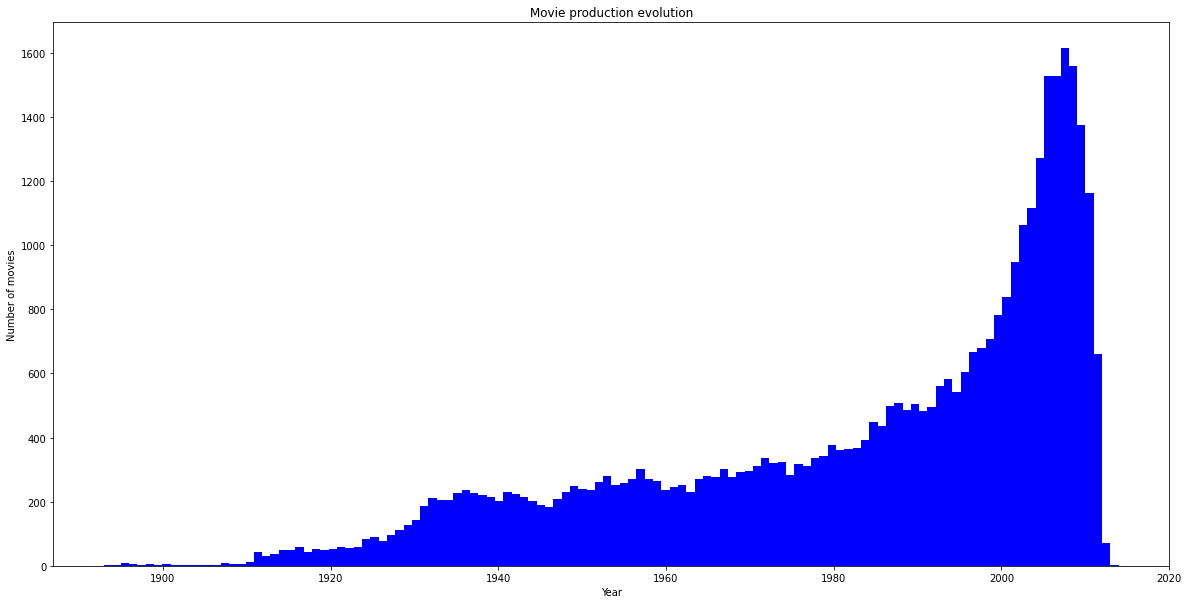

In [33]:
# 2.1 movie production evolution
fig, ax = plt.subplots(figsize=(20, 10))
ax.hist(df["release_year"], bins=(2014-1893+1), color="blue")
ax.set_xlabel("Year")
ax.set_ylabel("Number of movies")
ax.set_title("Movie production evolution")
plt.savefig('./img/'+'Movie_production_evolution.png')
plt.show()

In [5]:
df["release_year"].describe()

count    39585.000000
mean      1983.639990
std         25.652412
min       1893.000000
25%       1966.000000
50%       1993.000000
75%       2005.000000
max       2014.000000
Name: release_year, dtype: float64

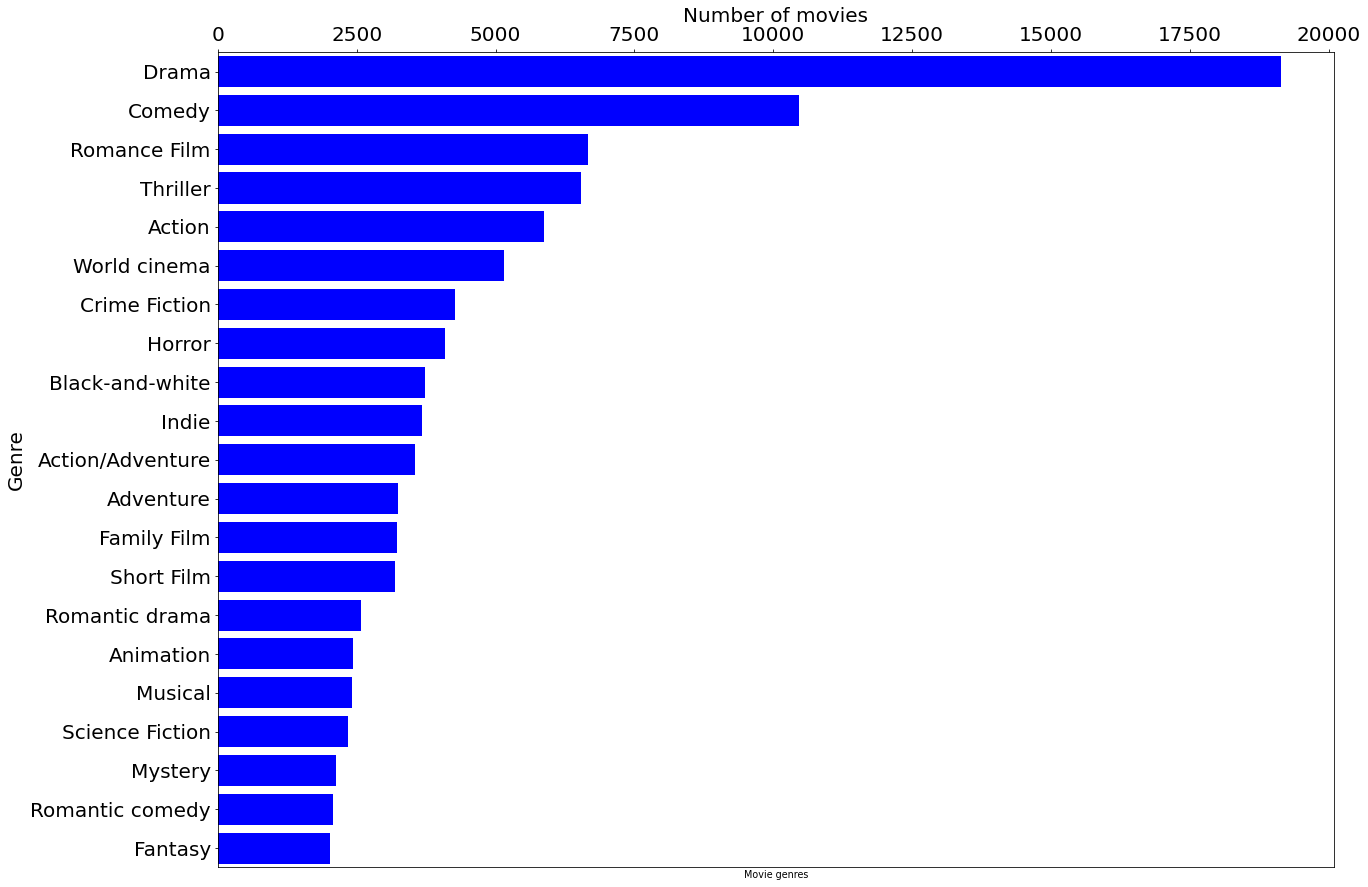

In [84]:

genres = df.genres.apply(lambda film: [genre for genre in literal_eval(film)]).explode().value_counts()
genres = genres[genres > 2000].sort_values(ascending=True)
fig, ax = plt.subplots(figsize=(20,15))
ax.barh(genres.index, genres.values, color="blue")
ax.set_ylabel("Genre")
ax.set_xlabel("Number of movies")
plt.rc('font', size=8) 
ax.set_title("Movie genres", y = -0.02)
plt.rc('font', size=20) 
plt.ylim([-0.5,genres.size-0.5])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
plt.savefig('./img/'+"genres_in_dataset.png",bbox_inches='tight')
plt.show()

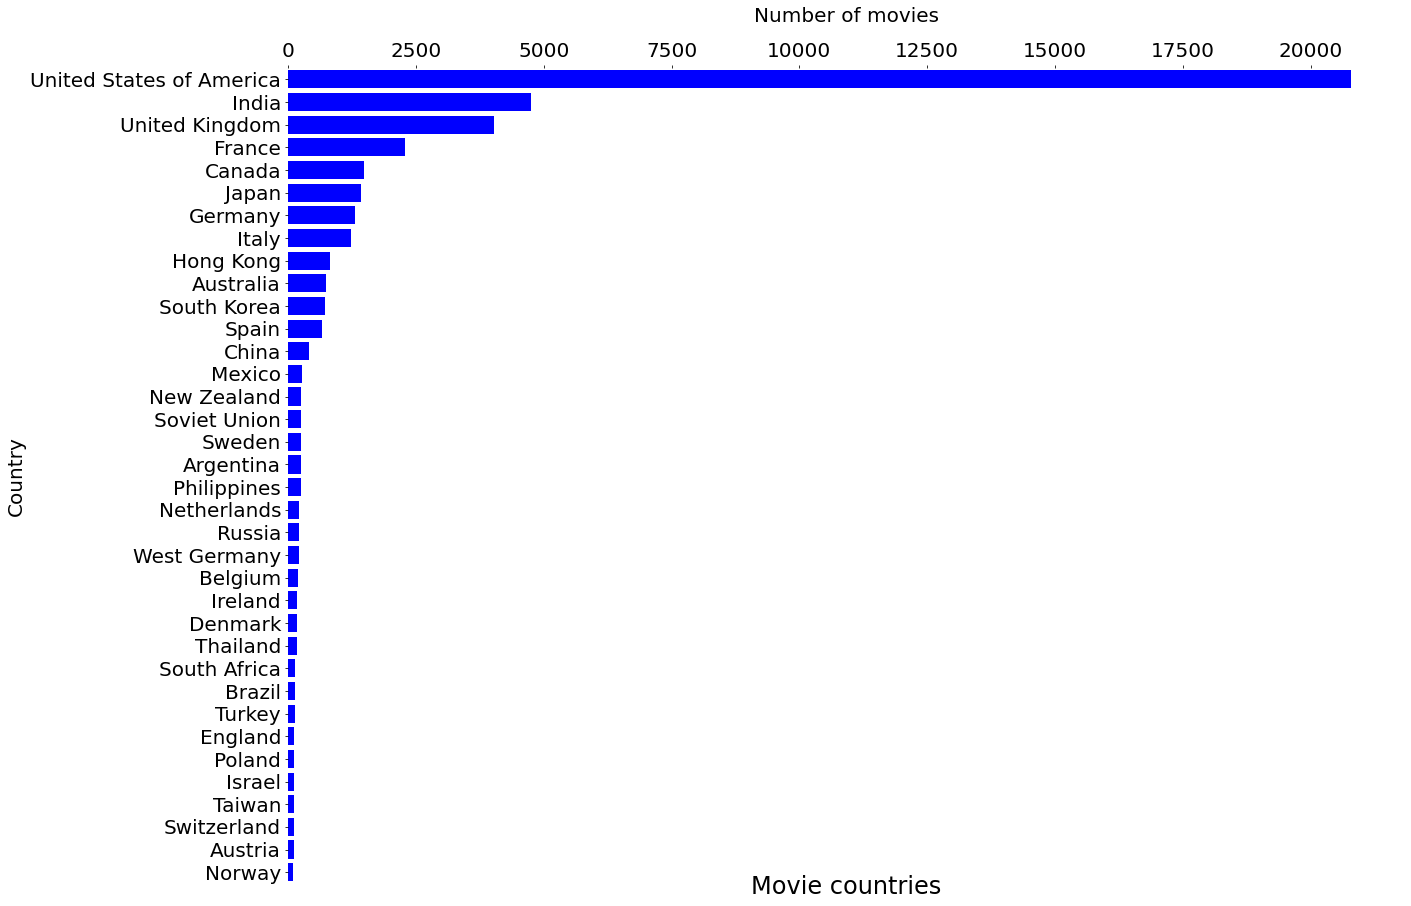

In [94]:
# TODO: move x axis to the top
countries = df.countries.apply(lambda film: [country for country in literal_eval(film)]).explode().value_counts()
countries = countries[countries > 100].sort_values(ascending=True)
fig, ax = plt.subplots(figsize=(20,15))
ax.barh(countries.index, countries.values, color="blue")
ax.set_ylabel("Country")
ax.set_xlabel("Number of movies")
ax.xaxis.labelpad = 20
ax.set_title("Movie countries",y=-0.02)
plt.ylim([-0.5,countries.size-0.5])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.xaxis.tick_top()
plt.rc('font', size=20) 
ax.xaxis.set_label_position('top') 
plt.savefig('./img/'+"Countries_in_dataset.png",bbox_inches='tight')
plt.show()

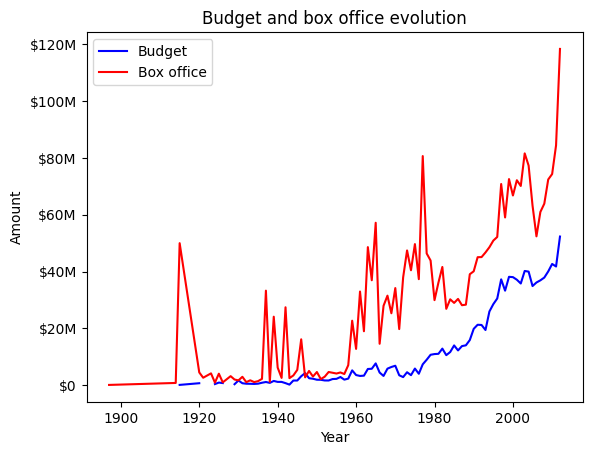

In [23]:
## for this one we need the revenue fetch from the API

fig, ax = plt.subplots()
box_office = df[df["movie_box_office_revenue"].notna()]
budget_by_year = box_office.groupby("release_year")["budget"].mean()
box_office_world_by_year = box_office.sort_values(["release_year"]).groupby("release_year")["movie_box_office_revenue"].mean()
ax.plot(budget_by_year.index, budget_by_year.values, color="blue", label="Budget")
ax.plot(box_office_world_by_year.index, box_office_world_by_year.values, color="red", label="Box office")
ax.set_xlabel("Year")
ax.set_ylabel("Amount")
ax.set_title("Budget and box office evolution")
ax.yaxis.set_major_formatter(currency)
ax.legend()
plt.show()

### Analysis for research question n*1

In [40]:
# We remove the movies with no release date since it will be impossible to include them in the time evolution (2619 movies removed)
df_r1 = df[df["release_year"].notna()]

#### Runtime evolution

In [41]:
# Cleaning runtime data

# soldiers of freedom is indeed a 6h movie
# Unsung heroes is actually 98 min long
# Swallow the sun is a TV series so indeed really long...
# heimat est une serie de films...
# once a eagle is a mini serie
df_r1.sort_values("movie_runtime", ascending=False)[["movie_name", "movie_runtime"]].head(10)


,movie_name,movie_runtime
6613,Zero Tolerance,1079281.00
14025,Kai Koduttha Dheivam,4875.27
37980,Gigantor,2425.00
37963,Dil Ne Phir Yaad Kiya,1966.00
12348,Swallow the Sun,1560.00
21635,Thiruthani,1440.00
36615,Unsung Heroes,1200.00
29584,Rebound,1003.00
18533,Heimat,900.00
15315,Vileness Fats,840.00


In [42]:
# Remove outliers
# We remove movies with a runtime higher than 6h as it corresponds mostly to TV series, mini series and errors (removed 20 movies)
df_runtime = df_r1[df_r1["movie_runtime"] < 450]

In [1]:
df_runtime.boxplot(column="movie_runtime", by="release_year", figsize=(20, 10), showfliers=False, style=".", grid=False)

NameError: name 'df_runtime' is not defined

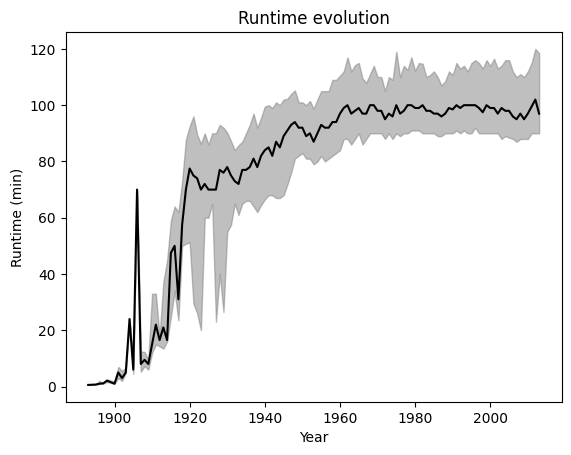

In [69]:
# Tries to plot the runtime evolution with seaborn
import seaborn as sns
#sns.plot_errorbars(x="release_year", y="movie_runtime", data=df_runtime, estimator="median", errobar=("pi",0.5))

#df_runtime.groupby("release_year")["movie_runtime"].median().plot()
df_runtim_gp = df_runtime.groupby("release_year")
a = df_runtim_gp.describe()["movie_runtime"]
plt.fill_between(a.index, a["25%"], a["75%"], alpha = 0.5, color = 'gray')
plt.plot(a["50%"], color = 'black')
plt.xlabel('Year')
plt.ylabel('Runtime (min)')
plt.title('Runtime evolution')
plt.show()
# plt.fill_between(stats_by_year.index, stats_by_year.average_worldwide_gross - stats_by_year.std_dev_worldwide_gross,
#                  stats_by_year.average_worldwide_gross + stats_by_year.std_dev_worldwide_gross, alpha = 0.5, color = 'gray')
# plt.plot(stats_by_year.average_worldwide_gross, color = 'black')

# plt.xlabel('Year')
# plt.ylabel('Worldwide gross revenue')


#### Number of character evolution

In [32]:
# Clean cast data
# We remove the movies with no cast (removed 17703 movies)
df_cast = df_r1[df_r1["cast"].notna()]
df_cast["cast_length"] = df_cast["cast"].apply(lambda cast: len(cast))
#df_cast.boxplot(column="cast_length", by="release_year", figsize=(20, 10))
type(df_cast["cast"].head(1).values[0])


/tmp/ipykernel_7375/411853124.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cast["cast_length"] = df_cast["cast"].apply(lambda cast: len(cast))


str

#### Ratio Men/Women evolution

In [ ]:
# TODO: try to do a graph nb of women in cast by year (or by decade) and another one with nb of men
def get_nb_actors(cast):
    return len(cast)

def get_nb_female_actors(cast):
    return None